# AR(p)

# Autoregressive Model
이전 수업에서 살펴본 Holt-Winters 계절성 기법을 사용한 이동 평균 모델에서 우리가 하려던 것은 예측 변수의 선형 조합을 사용해 관심 변수를 예측하는 것이었다. 앞선 예에서 수준, 추세 및 계절 예측 변수를 기반으로 항공사 승객 수를 예측할 수 있었다.  
Autoregression 모델에선 변수의 과거의 값의 선형 조합의 변수을 이용하여 그 변수를 예측한다. *autoregression*이라는 용어는 해당 변수애 댜헌 회귀를 뜻하며 Autoregression 모델은 일련의 lag된 값인 차수 $p$에 의해 실행된다. 자기 회귀 모델은 출력 변수가 자체의 이전값과 확률항에 선형적으로 독립적이라는 가정하에 작동한다. 일종의 잡읍항으로 불완전하게 예측할 수 있는 항이다. AR 모델은 이동 평균 모델과 더불어 특수한 경우이며, 보다 일반적인 모델인 ARIMA 및 ARMA의 핵심 구성요소이다. 

<br>

${\displaystyle y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \dots + \phi_{p}y_{t-p} + \varepsilon_{t}}$  
$c$: 상수항  
$\phi_{1}, \phi_{2}$: 최대 $p$까지의 lag 계수  
$\varepsilon_{t}$: 백색잡음

<br>

예를 들어,  <strong>AR(1)</strong> model은 아래의 공식으로 계산된다.  
&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \varepsilon_{t}$  
반면, <strong>AR(2)</strong>은 아래의 공식에 의해 계산된다:  
&nbsp;&nbsp;&nbsp;&nbsp;$y_{t} = c + \phi_{1}y_{t-1} + \phi_{2}y_{t-2} + \varepsilon_{t}$  
하지만 너무 먼 과거 시점으로 가면 예측항과 관련성이 없는 백색 잡음도 섞일 수 있기 때문에 일정 정도의 lag값이 필요하다.
<br>
일반적으로 Autoregressive model은 stationary data로 제한하기 때문에 lag coeffient는 1보다 작다.  
특히, <strong>AR(1)</strong> model의 경우: $-1 \lt \phi_1 \lt 1$<br>
<strong>AR(2)</strong> model의 경우엔: $-1 \lt \phi_2 \lt 1, \ \phi_1 + \phi_2 \lt 1, \ \phi_2 - \phi_1 \lt 1$<br>
<strong>AR(2)</strong> model의 경우엔 수학적으로 복잡해지지만 statsmodels이 이를 계산해준다.

## Perform standard imports and load datasets
이번 예에선 우리는 2011년 1월부터 2018년 12월까지 8년의 데이터와 96개의 관찰값을 가진 monthly U.S. 인구 예측치 dataset에 대해 공부할 것이다. 이때 인구는 국내에 있는 인원들 뿐만이 아니라 해외 파병 인원을 포함하는 단위다. 이 월단위 예측치는 월 1일과 다음달 1일의 추정치 평균이다. 자기 회귀 모델은 매우 간단해서 명확한 선형 증가 또는 감소 추세를 보이는 아주 단순한 데이터셋에만 적용이 가능하다. 

In [1]:
from statsmodels.tsa.ar_model import AR, ARResults
import pandas as pd
import numpy as np

df = pd.read_csv('../Data/uspopulation.csv',
                index_col='DATE',
                parse_dates=True)
df.index.freq = 'MS'

In [2]:
df.head()

,PopEst
DATE,
2011-01-01,311037
2011-02-01,311189
2011-03-01,311351
2011-04-01,311522
2011-05-01,311699


## Plot the source data

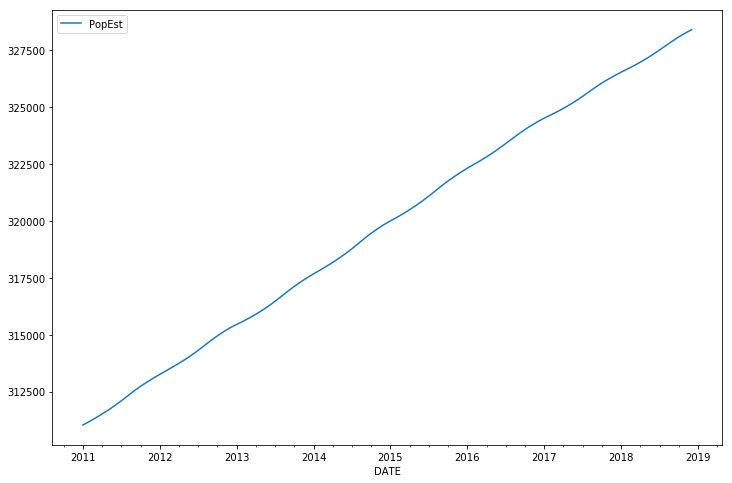

In [3]:
df.plot(figsize=(12, 8)); # 약간의 계절적 요인이 있지만 이는 무시할 정도로 작고 상당히 선형적인 추세가 나타나고 있다.

## Split the data into train/test set
이 소단원의 목적은 다음과 같다.
* 모델에 적용(fit)시킬 data를 training set로 분할
* 위에서 분할하고 남은 testing set로 모델을 평가함
* 총 data의 관측치로 model에 다시 적용(fit)한다.
* model을 사용하여 미래 값들을 예측한다.

일반적으로 test set의 크기는 원하는 예측 기간의 크기와 동일하여야 한다. 즉, 월별 데이터 세트의 경우 1년을 예측한다고 하였을 땐 test set의 길이 또한 1년이 되어야 한다.

<div class="alert alert-info"><strong>Note: </strong> 데이터 분할에 많이 사용하는 scikit-learn의 <tt>train_test_split()</tt>의 경우, 이 때는 사용하지 못하는데 그 이유는 데이터를 분할할 때 모집단으로부터 random하게 값들을 분할하기 때문이다.
</div>

In [4]:
len(df)

96

In [5]:
train = df.iloc[:84]
test = df.iloc[84:]

## Fit an AR(1) Model

In [6]:
model = AR(train['PopEst'])
AR1fit = model.fit(maxlag=1)

AR.fit() 안의 메소드  
- maxlag= 사용할 자기 회귀 모델의 차수(lag)를 정의함  
- method= 함수의 방정식을 푸는 방법을 설정  
    - 'cmle'= OLS를 사용하는 조건 최대 우도 추정법  
    - 'mle'= 무조건 (정확) 최대 우도  

이러한 메소드들은 GridSearchCV를 통해 최적의 평가점수를 찾아낼 필요가 있다.

<div class="alert alert-info">Holt-Winters 지수 평활법에서 .fit()방법으로 반환되는 객체와 AR로 반환되는 객체는 차이점이 있다. Holt-Winters 개체는 예측 값으로 .forecast()를 사용하는 반면 AR은 .predict()를 사용한다.
</div>

In [7]:
print(AR1fit.k_ar)  # 몇 단계의 시차로 이뤄진 모델인지를 출력(fit에서 maxlag로 설정한 값)
AR1fit.params       # 상수항과 lag coefficient를 반환 -> 즉, 한 단계 미래 시점의 예측값을 알아내는 데 사용할 방정식을 만듦

1


const        284.913797
L1.PopEst      0.999686
dtype: float64

In [8]:
start = len(train)   # 학습 데이터의 길이
end = len(train) + len(test) - 1 # 데이터 프레임 길이의 끝점에서 바로 하나 전에 있는 숫자

actual_pred = test.copy()
actual_pred['prediction'] = round(AR1fit.predict(start=start, end=end), 2)
actual_pred['Error'] = actual_pred['PopEst'] - actual_pred['prediction']
actual_pred

,PopEst,prediction,Error
DATE,,,
2018-01-01,326527,326560.40,-33.40
2018-02-01,326669,326742.75,-73.75
2018-03-01,326812,326925.04,-113.04
2018-04-01,326968,327107.27,-139.27
2018-05-01,327134,327289.44,-155.44
2018-06-01,327312,327471.56,-159.56
2018-07-01,327502,327653.62,-151.62
2018-08-01,327698,327835.62,-137.62
2018-09-01,327893,328017.57,-124.57


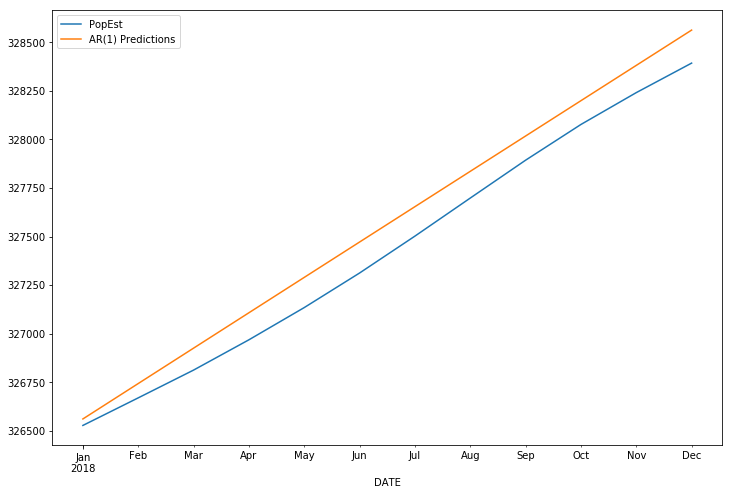

In [9]:
predictions1 = AR1fit.predict(start=start, end=end)
predictions1 = predictions1.rename('AR(1) Predictions')

test.plot(figsize=(12, 8), legend=True)
predictions1.plot(legend=True);

## Fit an AR(2) Model

In [10]:
AR2fit = model.fit(maxlag=2)
AR2fit.params

const        137.368305
L1.PopEst      1.853490
L2.PopEst     -0.853836
dtype: float64

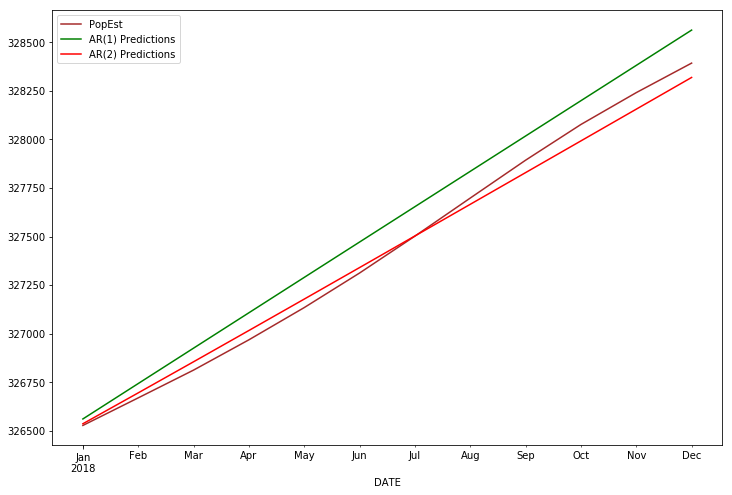

In [11]:
predictions2 = AR2fit.predict(start, end)
predictions2 = predictions2.rename('AR(2) Predictions')

test.plot(figsize=(12, 8), legend=True, color='brown')
predictions1.plot(legend=True, color='green')
predictions2.plot(legend=True, color='red');

## Fit an AR(p) model where statsmodels chooses p

In [12]:
ARfit = model.fit(ic='t-stat') 
# maxlag에 아무것도 입력하지 않으면 statmodels이 최적의 차수를 찾아줌
# ic = 최적 시차 길이를 선택하기 위해 사용되는 기준 (일반적인 시계열 데이터에선 AIC가 일반적임)

In [13]:
ARfit.params
# statmodels recommends = L8

const        82.309677
L1.PopEst     2.437997
L2.PopEst    -2.302100
L3.PopEst     1.565427
L4.PopEst    -1.431211
L5.PopEst     1.125022
L6.PopEst    -0.919494
L7.PopEst     0.963694
L8.PopEst    -0.439511
dtype: float64

## Evaluate the Model

In [14]:
predictions8 = ARfit.predict(start, end)
predictions8 = predictions8.rename('AR(8) Predictions')

In [15]:
from sklearn.metrics import mean_squared_error

labels = ['AR1', 'AR2', 'AR8']
preds = [predictions1, predictions2, predictions8]

In [16]:
for i in range(3):
    error = mean_squared_error(test['PopEst'], preds[i])
    print(f'{labels[i]} MSE was: {error}')

AR1 MSE was: 17449.714240543028
AR2 MSE was: 2713.2586479327815
AR8 MSE was: 186.9741517770251


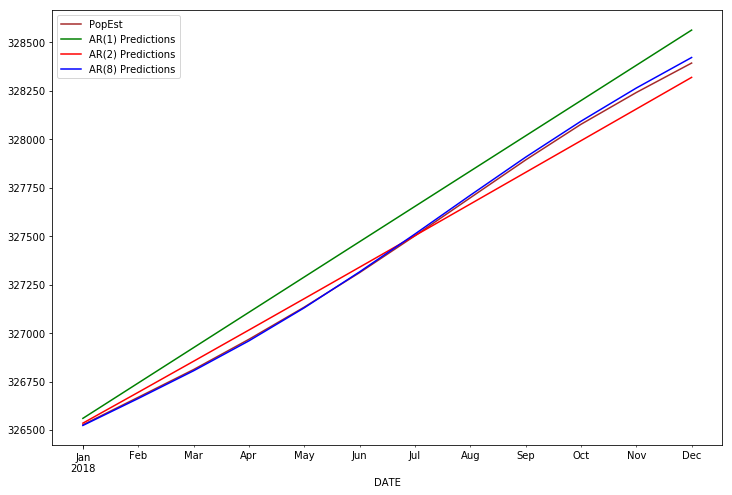

In [17]:
test.plot(figsize=(12, 8), legend=True, color='brown')
predictions1.plot(legend=True, color='green')
predictions2.plot(legend=True, color='red')
predictions8.plot(legend=True, color='blue');

## Forecasting

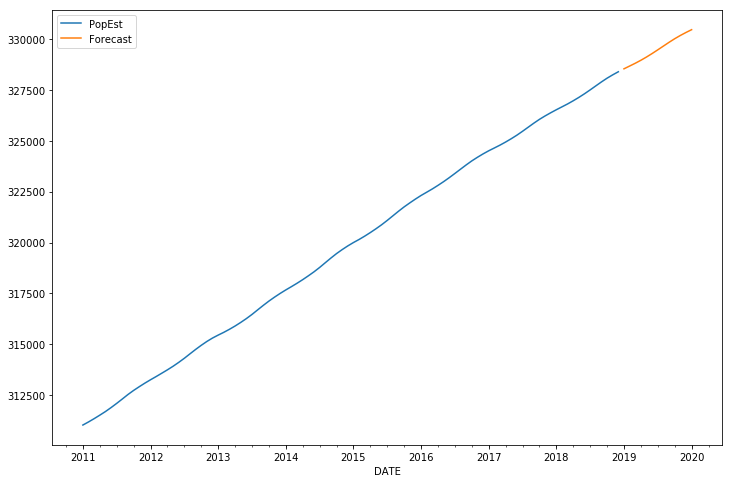

In [42]:
# 전체 데이터셋에 대해서 다시 train한다.
model = AR(df['PopEst'])

# model에 fit한다.
ARfit = model.fit()

# prediction을 진행한다. 
forcasted_values = ARfit.predict(start=len(df), end=len(df)+12).rename('Forecast')

# 결과를 Plotting한다.
df['PopEst'].plot(figsize=(12, 8), legend=True)
forcasted_values.plot(legend=True);